# Code to evaluate EKE in NeverWorld2 and compare results from different configurations

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Latin Modern Roman"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['mathtext.fontset'] = "cm"
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import xarray as xr
from xgcm import Grid
import numpy as np
import cmocean
import datetime
import pandas as pd

In [2]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Comparison of total energy

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


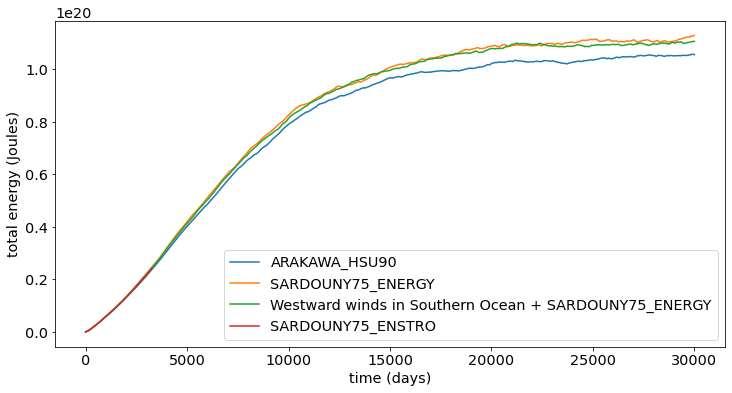

In [4]:
run = [9,13,8,10]

plt.figure(figsize=(12,6))

for i in range(len(run)):
    os = xr.open_dataset('run%i/ocean.stats.nc' % run[i], decode_times=False)
    plt.plot(os.Time,os.En)
    
plt.xlabel('time (days)')
plt.ylabel('total energy (Joules)')
plt.gca().legend(('ARAKAWA_HSU90','SARDOUNY75_ENERGY','Westward winds in Southern Ocean + SARDOUNY75_ENERGY','SARDOUNY75_ENSTRO'))

plt.savefig('energy_vs_time.png', dpi=200,bbox_inches='tight',pad_inches=0)

## CFL check for the failed run relative to a reference case

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.

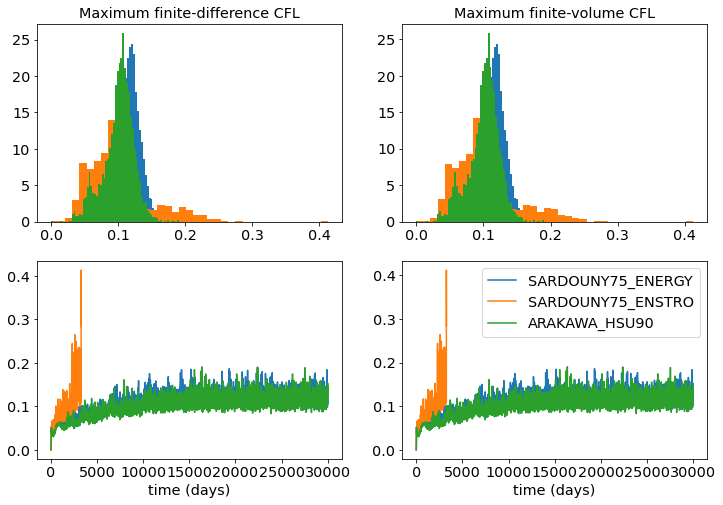

In [85]:
# for the failed run 
failed_run = [13,10,9]

plt.figure(figsize=(12,8))

for i in range(len(failed_run)):
    os = xr.open_dataset('run%i/ocean.stats.nc' % failed_run[i], decode_times=False)
    plt.subplot(2,2,1)
    plt.hist(os.max_CFL_lin, bins='auto', density=True)
    plt.title('Maximum finite-difference CFL')

    plt.subplot(2,2,2)
    plt.hist(os.max_CFL_trans, bins='auto', density=True)
    plt.title('Maximum finite-volume CFL')

    plt.subplot(2,2,3)
    plt.plot(os.Time,os.max_CFL_lin)
    plt.xlabel('time (days)')

    plt.subplot(2,2,4)
    plt.plot(os.Time,os.max_CFL_trans)
    plt.xlabel('time (days)')

plt.gca().legend(('SARDOUNY75_ENERGY','SARDOUNY75_ENSTRO','ARAKAWA_HSU90'))
plt.savefig('CFL_SARDOUNY75_ENSTRO.png', dpi=200,bbox_inches='tight',pad_inches=0)

## Comparison of velocities (effective and diagnosed)

In [6]:
tau = 5*86400 # seconds
end_time = 30000
start_time = end_time - tau/86400
run=13

In [7]:
av = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)
st = xr.open_dataset('run%i/static.nc' % run, decode_times=False)

In [25]:
def interp_h_to_u(h):
    n,layers,ly,lx = h.shape
    h_at_u = np.zeros((n,layers,ly,lx+1))
    h_at_u[:,:,:,1:-1] = (h[:,:,:,:-1] + h[:,:,:,1:])/2
    h_at_u[:,:,:,0] = (h[:,:,:,0] + h[:,:,:,-1])/2 # periodic
    h_at_u[:,:,:,-1] = (h[:,:,:,0] + h[:,:,:,-1])/2 # periodic
    
    return h_at_u
    
def interp_h_to_v(h):
    n,layers,ly,lx = h.shape
    h_at_v = np.zeros((n,layers,ly+1,lx))
    h_at_v[:,:,1:-1,:] = (h[:,:,:-1,:] + h[:,:,1:,:])/2
    h_at_v[:,:,0,:] = h[:,:,0,:] # non-periodic
    h_at_v[:,:,-1,:] = h[:,:,-1,:] # non-periodic
    
    return h_at_v

h_at_u = interp_h_to_u(av.h.values.astype(float)) # m
u_eff = (av.uh.astype(float))/(h_at_u*st.dyCu.values.astype(float) + 1e-20) # m/s 
u_eff = u_eff.sel(time=slice(start_time,end_time)).values.astype(float)
u_diag = av.u.sel(time=slice(start_time,end_time)).values.astype(float)

h_at_v = interp_h_to_v(av.h.values.astype(float))
v_eff = (av.vh.astype(float))/(h_at_v*st.dxCv.values.astype(float) + 1e-20) # m/s 
v_eff = v_eff.sel(time=slice(start_time,end_time)).values.astype(float)
v_diag = av.v.sel(time=slice(start_time,end_time)).values.astype(float)

In [ ]:
print(u_diag.shape,u_eff.shape)
plt.figure(figsize=(15,14))
plt.subplot(2,2,1)
plt.scatter(u_diag,u_eff)
plt.plot([np.nanmin(u_diag),np.nanmax(u_diag)],[np.nanmin(u_diag),np.nanmax(u_diag)],'k-')
plt.xlabel('Model diagnosed u')
plt.ylabel('Effective u')
plt.grid()

plt.subplot(2,2,2)
plt.scatter(v_diag,v_eff)
plt.plot([np.nanmin(v_diag),np.nanmax(v_diag)],[np.nanmin(v_diag),np.nanmax(v_diag)],'k-')
plt.xlabel('Model diagnosed v')
plt.ylabel('Effective v')
plt.grid()

plt.subplot(2,2,3)
u_error = (u_diag - u_eff)/(u_diag)
plt.hist(u_error.astype(float).flatten(),bins='auto',histtype='step')
plt.xlabel('Mean difference')
plt.xlim((-2,2))
plt.ylim((0,100))
plt.grid()

plt.subplot(2,2,4)
v_error = (v_diag - v_eff)/(v_diag)
plt.hist(v_error.astype(float).flatten(),bins='auto',histtype='step')
plt.xlabel('Mean difference')
plt.xlim((-2,2))
plt.ylim((0,100))
plt.grid()

plt.savefig('scatter_velocities_start_time_%i_days_end_time_%i_days.png' % (start_time,end_time), dpi=200,bbox_inches='tight',pad_inches=0)

plt.show()

(1, 15, 560, 241) (1, 15, 560, 241)


/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/numpy/lib/histograms.py:403: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/numpy/lib/histograms.py:404: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


# Reynolds averaged EKE

In [7]:
tau = 500*86400 # seconds
end_time = 30000
start_time = end_time - tau/86400
run = 13

av = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)
lm = xr.open_dataset('run%i/longmean_00028250.nc' % run, decode_times=False)
st = xr.open_dataset('run%i/static.nc' % run, decode_times=False)

In [8]:
area_u = st.area_u.values.astype(float) # m^2
area_v = st.area_v.values.astype(float) # m^2
area_t = st.area_t.values.astype(float) # m^2
H = st.depth_ocean.values.astype(float) # m

In [9]:
h_temp = av.h.sel(time=slice(start_time,end_time)).values.astype(float)
u_temp = av.u.sel(time=slice(start_time,end_time)).values.astype(float)
v_temp = av.v.sel(time=slice(start_time,end_time)).values.astype(float)
TKE_temp = lm.KE.sel(time=slice(start_time,end_time)).values.astype(float)

# These are tau day averages of the 5-day averages
h_fine = h_temp.mean(axis=0) # m
TKE = TKE_temp.mean(axis=0) # m^2/s^2
u_fine = u_temp.mean(axis=0) # m/s
v_fine = v_temp.mean(axis=0) # m/s

In [10]:
grid = Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} }, periodic=['X'])


def interp_u2_to_center(u):
    layers,ly,lx_p_1 = u.shape
    lx = lx_p_1 - 1
    u_center = np.zeros((layers,ly,lx))
    u_center[:,:,:] = (u[:,:,:-1] + u[:,:,1:])/2
    u_center[:,:,0] = (u[:,:,0] + u[:,:,-1])/2 # periodic
    u_center[:,:,-1] = (u[:,:,0] + u[:,:,-1])/2 # periodic
    
    return u_center
    
def interp_v2_to_center(v):
    layers,ly_p_1,lx = v.shape
    ly = ly_p_1 - 1
    v_center = np.zeros((layers,ly,lx))
    v_center[:,:,:] = (v[:,:-1,:] + v[:,1:,:])/2
    
    return v_center

u2_temp = u_fine*u_fine*area_u
v2_temp = v_fine*v_fine*area_v

MKE = 0.5*(interp_u2_to_center(u2_temp) + interp_v2_to_center(v2_temp))/area_t

In [11]:
MKE.shape

(15, 560, 240)

In [12]:
EKE = TKE - MKE
xh = st.xh
yh = st.yh

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


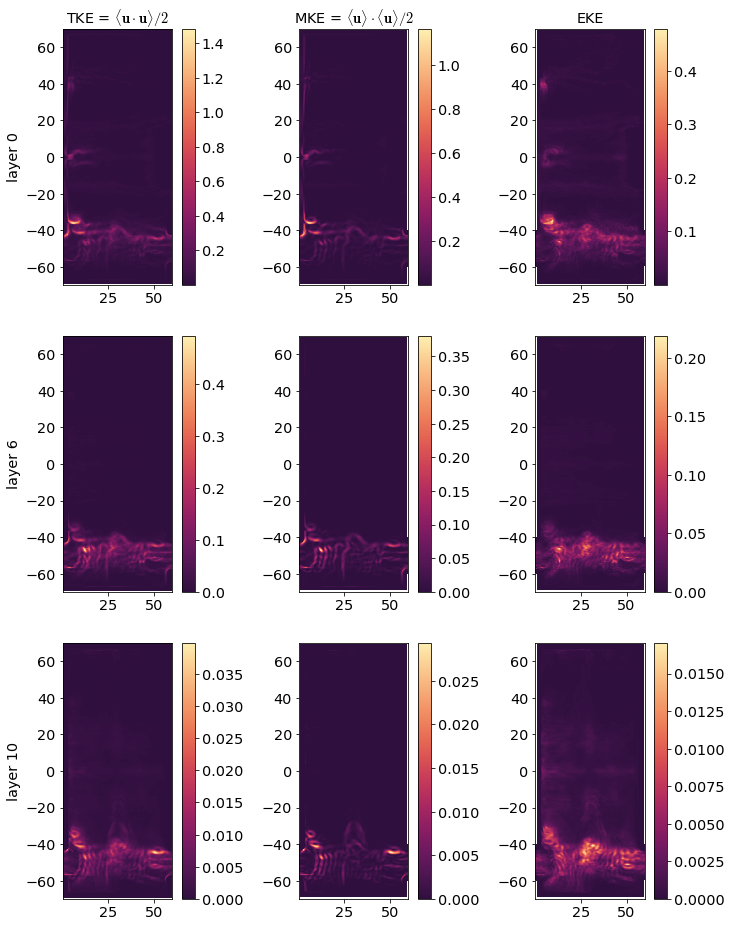

In [13]:
plt.figure(figsize=(12,16))

l = 0

# vmin = np.nanmin(EKE[l])
# vmax = np.nanmax(TKE[l])

plt.subplot(3,3,1)
plt.pcolormesh(xh,yh,TKE[l], cmap=cmocean.cm.matter_r)
plt.ylabel(r'layer %i' %l)
plt.title(r'TKE = $\langle \mathbf{u} \cdot \mathbf{u} \rangle/2$')
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

plt.subplot(3,3,2)
plt.pcolormesh(xh,yh,MKE[l], cmap=cmocean.cm.matter_r)
plt.title(r'MKE = $\langle \mathbf{u} \rangle\cdot \langle  \mathbf{u} \rangle/2$')
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

plt.subplot(3,3,3)
plt.pcolormesh(xh,yh,EKE[l], cmap=cmocean.cm.matter_r)
plt.title('EKE')
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

l = 6

# vmin = np.nanmin(EKE[l])
# vmax = np.nanmax(TKE[l])

plt.subplot(3,3,4)
plt.pcolormesh(xh,yh,TKE[l], cmap=cmocean.cm.matter_r)
plt.ylabel(r'layer %i' %l)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

plt.subplot(3,3,5)
plt.pcolormesh(xh,yh,MKE[l], cmap=cmocean.cm.matter_r)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

plt.subplot(3,3,6)
plt.pcolormesh(xh,yh,EKE[l], cmap=cmocean.cm.matter_r)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

l = 10

# vmin = np.nanmin(EKE[l])
# vmax = np.nanmax(TKE[l])

plt.subplot(3,3,7)
plt.pcolormesh(xh,yh,TKE[l], cmap=cmocean.cm.matter_r)
plt.ylabel(r'layer %i' %l)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

plt.subplot(3,3,8)
plt.pcolormesh(xh,yh,MKE[l], cmap=cmocean.cm.matter_r)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

plt.subplot(3,3,9)
plt.pcolormesh(xh,yh,EKE[l], cmap=cmocean.cm.matter_r)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()


plt.savefig('Energy_start_time_%i_days_tau_%i_days.png' % (start_time,tau/86400), dpi=200,bbox_inches='tight',pad_inches=0)

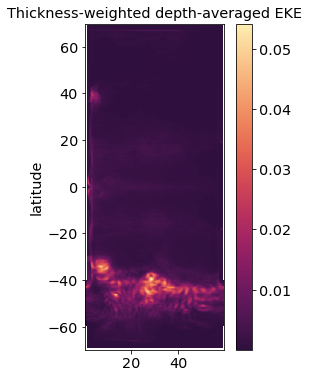

In [14]:
EKE_depth_averaged_temp = EKE*h_fine/(H)

EKE_depth_averaged = EKE_depth_averaged_temp.sum(axis=0)

plt.figure(figsize=(4,6))

plt.pcolormesh(xh,yh,EKE_depth_averaged, cmap=cmocean.cm.matter_r)
plt.ylabel('longitude')
plt.ylabel('latitude')
plt.title('Thickness-weighted depth-averaged EKE')
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

plt.savefig('EKE_start_time_%i_days_tau_%i_days.png' % (start_time,tau/86400), dpi=200,bbox_inches='tight',pad_inches=0)

In [15]:
EKE_depth_averaged.shape

(560, 240)

# Coarsening

In [128]:
tau = 5*86400 # seconds
end_time = 30000
start_time = end_time - tau/86400
run = 13
coarsen = 2

av = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)
st = xr.open_dataset('run%i/static.nc' % run, decode_times=False)

In [129]:
xh_c = st.xh.values.reshape(-1,coarsen).mean(axis=1)
yh_c = st.yh.values.reshape(-1,coarsen).mean(axis=1)

In [130]:
# These are the raw 5-day average data 
h_fine = av.h.sel(time=slice(start_time,end_time)).values.astype(float)
u_fine = av.u.sel(time=slice(start_time,end_time)).values.astype(float)
v_fine = av.v.sel(time=slice(start_time,end_time)).values.astype(float)

In [131]:
def coarsen_KE(TKE):
    n,l,ly,lx = TKE.shape 
    TKE_c = np.zeros((n,l,ly//coarsen,lx//coarsen))
    for j in range(coarsen):
        for i in range(coarsen):
            TKE_c[:,:,:,:] = TKE_c[:,:,:,:] + TKE[:,:,j::coarsen,i::coarsen]
    
    return TKE_c/coarsen**2

In [137]:
def coarsen_u(u_fine):
    """It returns the mean over j"""
    n,l,ly,lx_p_1 = u_fine.shape 
    lx = lx_p_1 - 1
    uc_coarse = np.zeros((n,l,ly//coarsen,lx//coarsen+1))
    
    # Coarsening uc to uc_coarse
    for j in range(coarsen):
        uc_coarse[:,:,:,:] = uc_coarse[:,:,:,:] + u_fine[:,:,j::coarsen,::coarsen]
    
    return uc_coarse/coarsen

def coarsen_v(v_fine):
    n,l,ly_p_1,lx = v_fine.shape 
    ly = ly_p_1 - 1
    vc_coarse = np.zeros((n,l,ly//coarsen+1,lx//coarsen))
    
    # Coarsening uc to uc_coarse
    for i in range(coarsen):
        vc_coarse[:,:,:,:] = vc_coarse[:,:,:,:] + v_fine[:,:,::coarsen,i::coarsen]
    
    return vc_coarse/coarsen

def project_u_to_fine(u_coarse):
    n,l,ly_coarsen,lx_coarsen_p_1 = u_coarse.shape 
    ly,lx = coarsen*ly_coarsen,coarsen*(lx_coarsen_p_1-1)
    uc_fine = np.zeros((n,l,ly,lx//coarsen+1))
    
    # Projecting onto the fine grid 
    for j in range(coarsen):
        uc_fine[:,:,j::coarsen,:] = u_coarse[:,:,:,:]
        
    return uc_fine

def project_v_to_fine(v_coarse):
    n,l,ly_coarsen_p_1,lx_coarsen = v_coarse.shape 
    ly,lx = coarsen*(ly_coarsen_p_1-1),coarsen*lx_coarsen
    vc_fine = np.zeros((n,l,ly//coarsen+1,lx))
    
    # Projecting onto the fine grid 
    for i in range(coarsen):
        vc_fine[:,:,:,i::coarsen] = v_coarse[:,:,:,:]
        
    return vc_fine

In [138]:
def interp_area_to_u(area_c):
    ly,lx = area_c.shape
    area_c_u = np.zeros((ly,lx+1))
    area_c_u[:,1:-1] = (area_c[:,:-1] + area_c[:,1:])/2
    area_c_u[:,0] = (area_c[:,0] + area_c[:,-1])/2 # periodic
    area_c_u[:,-1] = (area_c[:,0] + area_c[:,-1])/2 # periodic
    
    return area_c_u
    
def interp_area_to_v(area_c):
    ly,lx = area_c.shape
    area_c_v = np.zeros((ly+1,lx))
    area_c_v[1:-1,:] = (area_c[:-1,:] + area_c[1:,:])/2
    area_c_v[0,:] = area_c[0,:] # non-periodic
    area_c_v[-1,:] = area_c[-1,:] # non-periodic
    
    return area_c_v

def interp_u2_to_center(u):
    n,layers,ly,lx_p_1 = u.shape
    lx = lx_p_1 - 1
    u_center = np.zeros((n,layers,ly,lx))
    u_center[:,:,:,:] = (u[:,:,:,:-1] + u[:,:,:,1:])/2
    u_center[:,:,:,0] = (u[:,:,:,0] + u[:,:,:,-1])/2 # periodic
    u_center[:,:,:,-1] = (u[:,:,:,0] + u[:,:,:,-1])/2 # periodic
    
    return u_center
    
def interp_v2_to_center(v):
    n,layers,ly_p_1,lx = v.shape
    ly = ly_p_1 - 1
    v_center = np.zeros((n,layers,ly,lx))
    v_center[:,:,:,:] = (v[:,:,:-1,:] + v[:,:,1:,:])/2
    
    return v_center

In [134]:
n,l,ly,lx = h_fine.shape

area_c = area_t.reshape((ly//coarsen,coarsen,lx//coarsen,coarsen)).sum(axis=-1).sum(axis=1) # m^2

u2_temp = u_fine*u_fine*area_u
v2_temp = v_fine*v_fine*area_v

TKE_temp = 0.5*(interp_u2_to_center(u2_temp) + interp_v2_to_center(v2_temp))/area_t

TKE_c = coarsen_KE(TKE_temp).mean(axis=0)
print(TKE_c.shape)

area_u_c = interp_area_to_u(area_c) # m^2
area_v_c = interp_area_to_v(area_c) # m^2

uc_coarse = coarsen_u(u_fine)
vc_coarse = coarsen_v(v_fine)

up_fine = 

u2_temp = uc_coarse*uc_coarse*area_u_c
v2_temp = vc_coarse*vc_coarse*area_v_c

MKE_temp = 0.5*(interp_u2_to_center(u2_temp) + interp_v2_to_center(v2_temp))/area_c
MKE_c = MKE_temp.mean(axis=0)

print(MKE_c.shape)

(15, 280, 120)
(15, 280, 120)


In [135]:
EKE_c = TKE_c - MKE_c

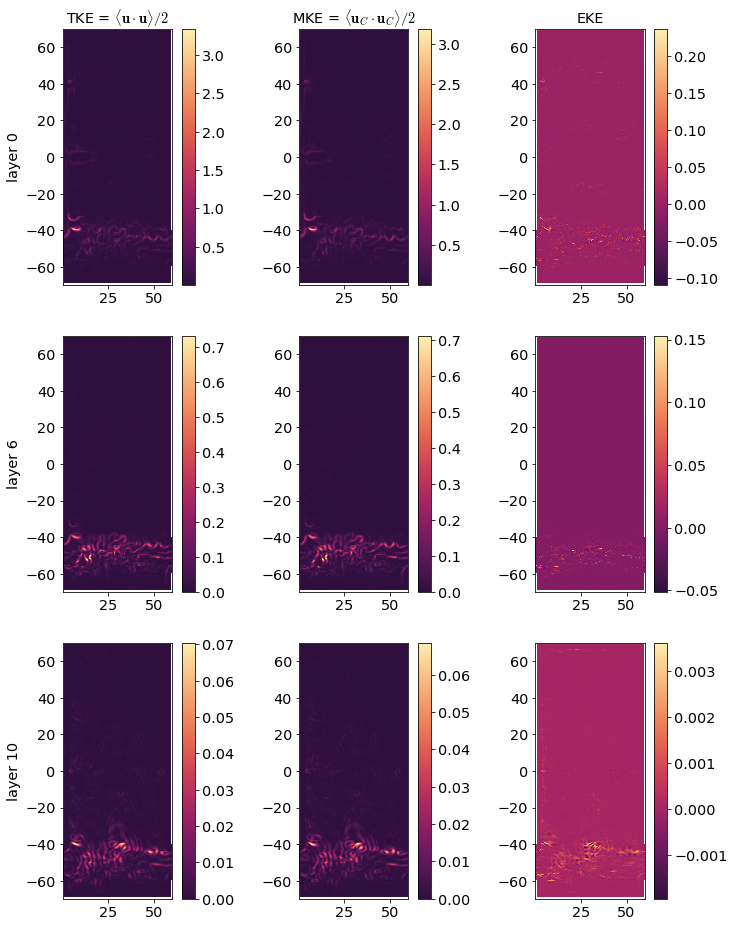

In [136]:
plt.figure(figsize=(12,16))

l = 0

# vmin = np.nanmin(EKE[l])
# vmax = np.nanmax(TKE[l])

plt.subplot(3,3,1)
plt.pcolormesh(xh_c,yh_c,TKE_c[l], cmap=cmocean.cm.matter_r)
plt.ylabel(r'layer %i' %l)
plt.title(r'TKE = $\langle \mathbf{u} \cdot \mathbf{u} \rangle/2$')
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

plt.subplot(3,3,2)
plt.pcolormesh(xh_c,yh_c,MKE_c[l], cmap=cmocean.cm.matter_r)
plt.title(r'MKE = $\langle \mathbf{u}_C \cdot  \mathbf{u}_C \rangle/2$')
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

plt.subplot(3,3,3)
plt.pcolormesh(xh_c,yh_c,EKE_c[l], cmap=cmocean.cm.matter_r)
plt.title('EKE')
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

l = 6

# vmin = np.nanmin(EKE[l])
# vmax = np.nanmax(TKE[l])

plt.subplot(3,3,4)
plt.pcolormesh(xh_c,yh_c,TKE_c[l], cmap=cmocean.cm.matter_r)
plt.ylabel(r'layer %i' %l)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

plt.subplot(3,3,5)
plt.pcolormesh(xh_c,yh_c,MKE_c[l], cmap=cmocean.cm.matter_r)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

plt.subplot(3,3,6)
plt.pcolormesh(xh_c,yh_c,EKE_c[l], cmap=cmocean.cm.matter_r)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

l = 10

# vmin = np.nanmin(EKE[l])
# vmax = np.nanmax(TKE[l])

plt.subplot(3,3,7)
plt.pcolormesh(xh_c,yh_c,TKE_c[l], cmap=cmocean.cm.matter_r)
plt.ylabel(r'layer %i' %l)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

plt.subplot(3,3,8)
plt.pcolormesh(xh_c,yh_c,MKE_c[l], cmap=cmocean.cm.matter_r)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()

plt.subplot(3,3,9)
plt.pcolormesh(xh_c,yh_c,EKE_c[l], cmap=cmocean.cm.matter_r)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xh.min(), xh.max(), yh.min(), yh.max()])
plt.colorbar()


plt.savefig('Energy_coarsen_%i_start_time_%i_days_tau_%i_days.png' % (coarsen,start_time,tau/86400), dpi=200,bbox_inches='tight',pad_inches=0)

## SSH videos

In [165]:
st = xr.open_dataset('run13/static.nc', decode_times=False)
xh = st.xh.values
yh = st.yh.values

run = [8,13,9]
ci = np.arange(-3.5,1.5,0.2)

end_time = 250-2000
while end_time < 27000:
    end_time = end_time + 2000
    print(end_time)
    filename = 'run8/longmean_'+'{0:08}'.format(end_time)+ '.nc'
    av1 = xr.open_dataset(filename, decode_times=False)
    filename = 'run13/longmean_'+'{0:08}'.format(end_time)+ '.nc'
    av2 = xr.open_dataset(filename, decode_times=False)
    filename = 'run9/longmean_'+'{0:08}'.format(end_time)+ '.nc'
    av3 = xr.open_dataset(filename, decode_times=False)
    e1 = av1.e.values[:,0]
    e2 = av2.e.values[:,0]
    e3 = av3.e.values[:,0]
    time = av1.time
    for i in range(len(time)):
        plt.figure(figsize=(12,4))
        plt.suptitle('Time = %.1f days' %time[i])
        plt.subplot(1,3,1)
        plt.contourf(xh,yh,e1[i], cmap=cmocean.cm.deep_r,levels = ci)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.clim(vmin, vmax)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.contourf(xh,yh,e2[i], cmap=cmocean.cm.deep_r,levels = ci)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.clim(vmin, vmax)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.contourf(xh,yh,e3[i], cmap=cmocean.cm.deep_r,levels = ci)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.clim(vmin, vmax)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.colorbar()
        save_name = 'SSH/fig_'+'{0:06}'.format(int(time[i]))+ '.png'
        plt.savefig(save_name, dpi=200,bbox_inches='tight',pad_inches=0)
        plt.close()

250
2250
4250
6250
8250
10250
12250
14250
16250
18250
20250
22250
24250
26250
28250


In [155]:
av1

<xarray.Dataset>
Dimensions:     (nv: 2, time: 4, xh: 240, xq: 241, yh: 560, yq: 561, zi: 16, zl: 15)
Coordinates:
  * xq          (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time        (time) float64 250.0 750.0 1.25e+03 1.75e+03
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yq          (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    u           (time, zl, yh, xq) float32 ...
    v           (time, zl, yq, xh) float32 ...
    h           (time, zl, yh, xh) float32 ...
    e           (time, zi, yh, xh) float32 nan nan nan nan ... nan nan nan nan
    uh          (time, zl, yh, xq) float32 ...
    vh          (time, zl, yq, xh) float32 ...
    cg1         (time, yh, xh) float32 ...
    Rd1         (time, yh, xh) float32 ...
    Rd_dx       (time, yh, xh) float32 ...
    KE          (time, zl, yh, xh) float32 ...
    average_T1  (time) float64 ...
    average_T2  (time) float64 ...
    average_DT  (time) float64 ...
    time_bnds   (time, nv) float64 ...
Attributes:
    filename:          longmean_00000250.nc
    title:             NeverWorld2
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A